# Plotting the ROC curve

It is not clear how to choose which metric(s) from the previous exercise to use to pick the best model for each of the three scenarios discussed in the video. In this exercise you will calculate the AUC scores and plot the ROC curves for both the kNN and the logistic regression models and use that information to decide which model is ideal for each of the scenarios.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
# Read the datafile "covid_train.csv"
train = pd.read_csv('covid_train.csv')
# Take a quick look at the dataframe
train.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,30,1,0,0,0,0,0,0,0
1,47,1,0,0,0,0,0,0,0
2,49,1,0,0,0,0,0,0,0
3,50,0,0,0,0,0,0,0,0
4,59,0,0,1,0,0,0,0,0


In [3]:
# Read the datafile "covid_test.csv"
test = pd.read_csv('covid_test.csv')
# Take a quick look at the dataframe
train.head()

,age,sex,cough,fever,chills,sore_throat,headache,fatigue,urgency
0,30,1,0,0,0,0,0,0,0
1,47,1,0,0,0,0,0,0,0
2,49,1,0,0,0,0,0,0,0
3,50,0,0,0,0,0,0,0,0
4,59,0,0,1,0,0,0,0,0


Separate the predictors from the response variables in both train and test sets.

In [4]:
### edTest(test_Xy) ###

# Get the train predictors
X_train = train.drop('urgency', axis=1)

# Get the train response variable
y_train = train['urgency']

# Get the test predictors
X_test = test.drop('urgency', axis=1)

# Get the test response variable
y_test = test['urgency']

We want to compare two different classifiers: kNN and logistic regression.

First, let's create a fit a kNN model and get's its predicted probabilities for the positive class on the test data.

**Hint:** Remember that the `predict_proba` method returns probabilities for all classes. We only want the probabilities for the positive class (i.e., $y = 1$). 

In [5]:
### edTest(test_kNN) ###

# Define a kNN classification model with k = 7
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the above model on the train data
knn.fit(X_train, y_train)

# Predict probabilities for the positive class on the test data using the kNN model
y_pred_knn = knn.predict_proba(X_test)[:,1]

Now let's do the same for a logistic regression model.

In [6]:
### edTest(test_logreg) ###

# Define a Logistic Regression model with max_iter as 10000, C as 0.1, and a random_state of 42
logreg = LogisticRegression(max_iter=1000, C=0.1, random_state=42)

# Fit the Logistic Regression model on the train data
logreg.fit(X_train, y_train)

# Predict probabilities for the positive class on the test data using the logistic regression model
y_pred_logreg = logreg.predict_proba(X_test)[:,1]

#### ROC Curve Review

The Bayes threshold of a binary classifier is the value for which all predicted probabilities greater than or equal to that value are labeled as the positive class. For example, a classifier with a Bayes threshold of 0.6 will classify all observations with a predicted probability, $p \geq 0.6$, as the positive class (1) and all observations with a predicted probability, $p < 0.6$, as the negative class (0).

The ROC curve shows us a model's false positive  and true positive rates across different settings of the Bayes Threshold. 

Recall that:
$$\text{False Positive Rate} = \frac{FP}{TN + FP}$$
$$\text{True Positive Rate} = \frac{TP}{TP + FN}$$

We will compute the false positve rate (FPR) and true positive rate (TPR) for a range of thresholds and use these values to plot ROC curves for both the kNN and the logistic regression models.

#### Thresholds

First, we need to generate a range of thresholds to use for turning our models' probability predictions into class labels. One naive approach might be to simply create a list of evenly spaced values between 0 and 1 and use these for both models. But this is not ideal. Consider the fact that some threshold changes will not actually affect the model's classification labels.

Example: if a model predicts probabilities `[0.54, 0.77, 0.79]` for 3 observations, all thresholds in the half-open interval (0.54, 0.77] will produce the exact same class labels: `[0, 1, 1]`

Another issue is that we may fail to see all changes in the class labels if our set of thresholds is not sufficiently granular. Consider the example of the 3 predicted probabilities above once more. If we use thresholds in steps of 0.05 (0, 0.05, 0.1, ..., 0.95, 1) we would only ever see class label predictions of [0, 1, 1] and [0, 0, 0]. We would miss an important threshold like 0.78 which would produce the class lables [0, 0, 1], potentially giving us a different TPR and FPR.

Our approach will be to evaluate just those thresholds that result in different class label predictions. And these precise thresholds will depend on our model.

Complete the `get_thresholds` function which takes a model's predicted probabilities on the test set and returns an array of thresholds to be considered.

In [7]:
def get_thresholds(y_pred_proba):
    # We only need to consider unique predicted probabilities
    unique_probas = np.unique(y_pred_proba)
    # Sort unique probabilities in descending order
    unique_probas_sorted = np.sort(unique_probas)[::-1]
   
    # We'll also add some additional thresholds to our set
    # This ensures our ROC curves reach the corners of the plot, (0,0) and (1,1)
    
    # Insert 1.1 at the beginning of the threshold array
    # 1.1 may seem like an odd threshold, but a value greater than 1
    # is required if we want the ROC curve to reach the lower left corner
    # (0 fpr, 0 tpr) considering one of our models produces probability predictions of 1
    thresholds = np.insert(unique_probas_sorted, 0, 1.1)
    # Append 0 to the end of the thresholds
    thresholds = np.append(thresholds, 0)
    return thresholds

In [8]:
### edTest(test_thresholds) ###

knn_thresholds = get_thresholds(y_pred_knn)

logreg_thresholds = get_thresholds(y_pred_logreg)

#### FPR & TPR

Now we can use the true $y$ class label and the predicted probabilities to determine the the fpr and tpr on the test data for a specific threshold. Complete the `get_fpr` and `get_tpr` functions below.

In [9]:
### edTest(test_fpr) ###

def get_fpr(y_true, y_pred_proba, threshold):
    # your code here

    # Predict the class labels based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    FP = np.sum((y_pred == 1) & (y_true == 0))
    TN = np.sum((y_pred == 0) & (y_true == 0))

    FPR = FP / (FP + TN)

    return FPR


In [10]:
### edTest(test_tpr) ###

def get_tpr(y_true, y_pred_proba, threshold):
    # your code here
    # Predict the class labels based on the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    FN = np.sum((y_pred == 0) & (y_true == 1))
    TP = np.sum((y_pred == 1) & (y_true == 1))

    TPR = TP / (TP + FN)

    return TPR

Use these functions to get the FPR and TPR for both models using each threshold for that model. These calculations can be done in a loop, but you should also try doing them with Python list comprehensions as well.

In [11]:
### edTest(test_fpr_tpr) ###

# FPR for the kNN at each of its thresholds
knn_fpr = [get_fpr(y_test, y_pred_knn, threshold) for threshold in get_thresholds(y_pred_knn)]
# TPR for the kNN at each of its thresholds
knn_tpr = [get_tpr(y_test, y_pred_knn, threshold) for threshold in get_thresholds(y_pred_knn)]

# TPR for the logistic model at each of its thresholds
logreg_tpr = [get_tpr(y_test, y_pred_logreg, threshold) for threshold in get_thresholds(y_pred_logreg)]
# FPR for the logistic model at each of its thresholds
logreg_fpr = [get_fpr(y_test, y_pred_logreg, threshold) for threshold in get_thresholds(y_pred_logreg)]

#### Area Under the Curve

The AUC gives us an idea as to how well our model does across *all* thresholds.

For our final calculations, use each model's predicted probabilities to compute its test AUC with the help of SKLearn's `roc_auc_score` function.

In [12]:
### edTest(test_auc) ###

# Compute the ROC AUC score of the kNN model
knn_auc = roc_auc_score(y_test, y_pred_knn)

# Compute the ROC AUC score of the Logistic model
logreg_auc = roc_auc_score(y_test, y_pred_logreg)

You're ready to visualize your results!

Most of the code is provided. You just need to fill in the values to be plotted for the two models' ROC curves.

Remember that the convention is that false positive rate is on the $x$-axis and true positive rate is on the $y$-axis.

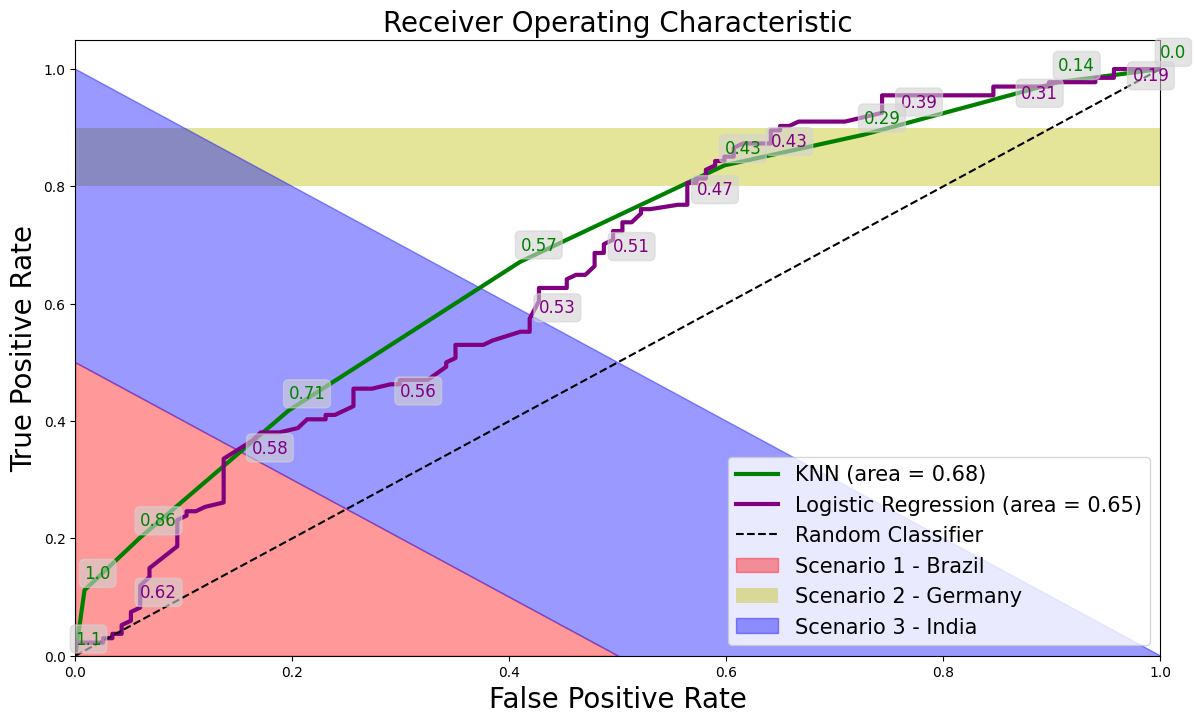

In [13]:
### edTest(test_plot) ###

# Area under curve - Logistic Regression & kNN
fig, ax = plt.subplots(figsize = (14,8))

# Plot KNN Regression ROC Curve
ax.plot(knn_fpr,
        knn_tpr,
        label=f'KNN (area = {knn_auc:.2f})',
        color='g',
        lw=3)

# Plot Logistic Regression ROC Curve
ax.plot(logreg_fpr,
        logreg_tpr,
        label=f'Logistic Regression (area = {logreg_auc:.2f})',
        color = 'purple',
        lw=3)

# Threshold annotations
label_kwargs = {}
label_kwargs['bbox'] = dict(
    boxstyle='round, pad=0.3', color='lightgray', alpha=0.6
)
eps = 0.02 # offset
for i in range(0, len(logreg_fpr),15):
    threshold = str(np.round(logreg_thresholds[i], 2))
    ax.annotate(threshold, (logreg_fpr[i], logreg_tpr[i]-eps), fontsize=12, color='purple', **label_kwargs)

for i in range(0, len(knn_fpr)-1):
    threshold = str(np.round(knn_thresholds[i], 2))
    ax.annotate(threshold, (knn_fpr[i], knn_tpr[i]+eps), fontsize=12, color='green', **label_kwargs)

# Plot diagonal line representing a random classifier
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Scenario 1 - Brazil
ax.fill_between([0,0.5],[0.5,0], color = 'red', alpha = 0.4, label='Scenario 1 - Brazil');

# Scenario 2 - Germany
ax.axhspan(0.8, 0.9, facecolor='y', alpha=0.4, label = 'Scenario 2 - Germany');

# Scenario 3 - India
ax.fill_between([0,1],[1,0],[0.5,-0.5], alpha = 0.4, color = 'blue', label = 'Scenario 3 - India');

ax.set_xlim([0.0, 1.0]);
ax.set_ylim([0.0, 1.05]);
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
ax.set_title('Receiver Operating Characteristic', fontsize=20)
ax.legend(loc="lower right", fontsize=15)
plt.show()

In [14]:
print(knn_auc)

0.6799017731853554
